In [1]:
from astropy.io import fits
import Transmission_calculation as trans
from astropy import units as u
import numpy as np
import math
from astropy.modeling.functional_models import Disk2D
from astropy.modeling.models import Gaussian2D
from astropy.modeling.models import Moffat2D
import matplotlib.pyplot as plt
plt.style.use('bmh')

def line(A,B):
    m=(A[1]-B[1])/(A[0]-B[0])
    c=A[1]-m*A[0] 
    return m,c

In [2]:
def make_aperture(type,scale,major_axis,hex_rotation=0):
    boundary=math.ceil(major_axis.value/2/scale) #radius of aperture in pixels
    if type == "circle":
    
        x = np.arange(-boundary, boundary+1)
        y = np.arange(-boundary, boundary+1)
        x, y = np.meshgrid(x, y)
 
        Disk=Disk2D(1,0,0,major_axis.value/2/scale)
        aperture=Disk(x,y)    

        return aperture
    
    if type == "5 hexagons":
        sampling = major_axis.value/3/scale
        aperture_array=np.zeros([boundary*2+1,boundary*2+1])

        triangle_side=sampling*np.sqrt(3)/3
        core = 2 * triangle_side * np.cos(np.pi/4)
        aperture_centre=[boundary,boundary]
        alpha = hex_rotation
        
        centre_0=aperture_centre
        centre_1=[centre_0[0]+sampling*np.cos(np.pi/2-alpha),centre_0[1]+sampling-sampling*(1-np.sin(np.pi/2-alpha))]
        centre_2=[centre_0[0]+np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.cos(np.pi/6-alpha),centre_0[1]+np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.sin(np.pi/6-alpha)]
        centre_3=[centre_0[0]+np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.cos(np.pi/6+alpha),centre_0[1]-np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.sin(np.pi/6+alpha)]
        centre_4=[centre_0[0]-sampling*np.cos(np.pi/2-alpha),centre_0[1]-sampling+sampling*(1-np.sin(np.pi/2-alpha))]
        centre_5=[centre_0[0]-np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.cos(np.pi/6-alpha),centre_0[1]-np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.sin(np.pi/6-alpha)]
        centre_6=[centre_0[0]-np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.cos(np.pi/6+alpha),centre_0[1]+np.sqrt((triangle_side*3/2)**2+(sampling/2)**2)*np.sin(np.pi/6+alpha)]

        centres=[centre_0,centre_1,centre_2,centre_3,centre_4,centre_5,centre_6]

        for centre in centres:
            if alpha == 0:
                P1=[centre[0]+triangle_side*np.cos(np.pi*1/3-alpha),centre[1]+triangle_side*np.sin(np.pi/3-alpha)]
                P2=[centre[0]+triangle_side*np.cos(alpha),centre[1]-triangle_side*np.sin(alpha)]
                P3=[centre[0]+triangle_side*np.cos(np.pi/3+alpha),centre[1]-triangle_side*np.sin(np.pi/3+alpha)]
                P4=[centre[0]-triangle_side*np.cos(np.pi/3-alpha),centre[1]-triangle_side*np.sin(np.pi/3-alpha)]
                P5=[centre[0]-triangle_side*np.cos(-alpha),centre[1]-triangle_side*np.sin(-alpha)]
                P6=[centre[0]-triangle_side*np.cos(np.pi/3+alpha),centre[1]+triangle_side*np.sin(np.pi/3+alpha)]

                L12_m,L12_c=line(P1,P2)
                L23_m,L23_c=line(P2,P3)
                L34_m,L34_c=line(P3,P4)
                L45_m,L45_c=line(P4,P5)
                L56_m,L56_c=line(P5,P6)
                L61_m,L61_c=line(P6,P1)           
                for y in range(0,len(aperture_array)):
                    for x in range(0,len(aperture_array)):           
                        if x < centre_0[0] + triangle_side * 2 and x > centre_0[0] - triangle_side * 2 and y < centre_0[1] + sampling and y > centre_0[1] - sampling: 
                            aperture_array[y][x]=1         
                        elif y < L61_m*x + L61_c and y > L34_m*x + L34_c and y < L12_m*x + L12_c and y > L23_m*x + L23_c and y > L45_m*x + L45_c and y < L56_m*x + L56_c:
                            aperture_array[y][x]=1  
            elif alpha != np.pi/6 and alpha != -np.pi/6:
                P1=[centre[0]+triangle_side*np.cos(np.pi*1/3-alpha),centre[1]+triangle_side*np.sin(np.pi/3-alpha)]
                P2=[centre[0]+triangle_side*np.cos(alpha),centre[1]-triangle_side*np.sin(alpha)]
                P3=[centre[0]+triangle_side*np.cos(np.pi/3+alpha),centre[1]-triangle_side*np.sin(np.pi/3+alpha)]
                P4=[centre[0]-triangle_side*np.cos(np.pi/3-alpha),centre[1]-triangle_side*np.sin(np.pi/3-alpha)]
                P5=[centre[0]-triangle_side*np.cos(-alpha),centre[1]-triangle_side*np.sin(-alpha)]
                P6=[centre[0]-triangle_side*np.cos(np.pi/3+alpha),centre[1]+triangle_side*np.sin(np.pi/3+alpha)]

                L12_m,L12_c=line(P1,P2)
                L23_m,L23_c=line(P2,P3)
                L34_m,L34_c=line(P3,P4)
                L45_m,L45_c=line(P4,P5)
                L56_m,L56_c=line(P5,P6)
                L61_m,L61_c=line(P6,P1)
                for y in range(0,len(aperture_array)):
                    for x in range(0,len(aperture_array)):
                        if y > centre_0[1] - core and y < centre_0[1] + core and x > centre_0[1] - core and x < centre_0[1] + core:
                            aperture_array[y][x]=1
                        elif y < L61_m*x + L61_c and y > L34_m*x + L34_c and y < L12_m*x + L12_c and y > L23_m*x + L23_c and y > L45_m*x + L45_c and y < L56_m*x + L56_c:
                            aperture_array[y][x]=1
                                
            elif alpha == np.pi/6 or alpha == - np.pi/6:
                P1=[centre[0]+triangle_side*np.cos(np.pi/3-alpha),centre[1]+triangle_side*np.sin(np.pi/3-alpha)]
                P2=[centre[0]+triangle_side*np.cos(alpha),centre[1]-triangle_side*np.sin(alpha)]
                P3=[centre[0]+triangle_side*np.cos(np.pi/3+alpha),centre[1]-triangle_side*np.sin(np.pi/3+alpha)]
                P4=[centre[0]-triangle_side*np.cos(np.pi/3-alpha),centre[1]-triangle_side*np.sin(np.pi/3-alpha)]
                P5=[centre[0]-triangle_side*np.cos(-alpha),centre[1]-triangle_side*np.sin(-alpha)]
                P6=[centre[0]-triangle_side*np.cos(np.pi/3+alpha),centre[1]+triangle_side*np.sin(np.pi/3+alpha)]
                
                L23_m,L23_c=line(P2,P3)
                L34_m,L34_c=line(P3,P4)
                L56_m,L56_c=line(P5,P6)
                L61_m,L61_c=line(P6,P1)
                
                for y in range(0,len(aperture_array)):
                    for x in range(0,len(aperture_array)):
                        if y < centre_0[1] + triangle_side * 2 and y > centre_0[1] - triangle_side * 2 and x < centre_0[0] + sampling and x > centre_0[0] - sampling: 
                            aperture_array[y][x]=1    
                        elif y < L61_m*x + L61_c and y > L34_m*x + L34_c and y > L23_m*x + L23_c and  y < L56_m*x + L56_c and x > centre[0] - sampling/2 and x < centre[0] + sampling/2:
                            aperture_array[y][x]=1    
        return aperture_array

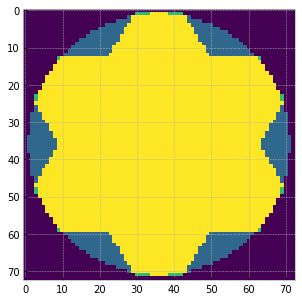

In [3]:
#VIS LR
circle=make_aperture("circle",0.01,0.702*u.arcsec)
hexagons=make_aperture("5 hexagons",0.01,0.702*u.arcsec)
plt.figure(figsize=[5,5])
plt.imshow(hexagons+circle*0.5)

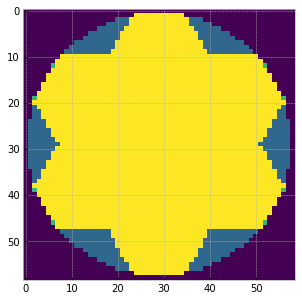

In [4]:
#NIR LR
circle=make_aperture("circle",0.01,0.190*3*u.arcsec)
hexagons=make_aperture("5 hexagons",0.01,0.190*3*u.arcsec)
plt.figure(figsize=[5,5])
plt.imshow(hexagons+circle*0.5)

In [5]:
def numerical_durham(aperture,PSF,offset,scale,axis_val=25,data_version=0):
    """
    Calculates transmission of Durham PSF offset from a circular aperture
    Numerical solution

    INPUTS:
    fibre_diameter: float, arcsec astropy units
        diameter of the fibre/aperture
    wavelength: array, nm astropy units, from [440,562,720,920,1202,1638]nm
        wavelength of the Durham PSF to use, corresponding to old band centres
    offset: float, arcsec astropy units
        offset of the PSF from the aperture
    axis_val: float, from [0-48]
        GLAO axis offset for the PSF. 25 is perfectly centred
    data_version: float, from [0,1]
        which Durham PSF to use; 0 is the original, 1 is the compressed data to ~0.01 arcsec

    OUTPUTS:
    Returns:
    transmission: float
        transmission value
    """
    durham_data=PSF

    offset = abs(offset)
    fibre_boundary=(len(aperture)-1)/2 #radius of aperture in pixels
    data_boundary=len(durham_data)

    resized_data=np.zeros([len(aperture),len(aperture)])
    durham_data=durham_data[int(data_boundary/2-fibre_boundary):int(data_boundary/2+fibre_boundary)+1,int(data_boundary/2-fibre_boundary+offset.value/scale):int(data_boundary/2+fibre_boundary+offset.value/scale)+1]
    resized_data[0:len(durham_data),0:len(durham_data[0])]=durham_data
    convolved=resized_data*aperture
    
    trans=sum(sum(convolved))

    return trans

In [12]:
def numerical_moffat(aperture,FWHM,offset,scale,beta=2.5):
    """
    Calculates transmission of Moffat PSF offset from a circular aperture
    Numerical solution

    INPUTS:
    fibre_diameter: float, arcsec astropy units
        diameter of the fibre/aperture
    FWHM: float, arcsec astropy units
        FWHM of the PSF
    offset: float, arcsec astropy units
        offset of the PSF from the aperture
    scale: float
        scale of the numerical simulation, arcsec/pixel
    beta: float
        power index of the moffat equation, (also known as atmospheric scattering coefficient)

    OUTPUTS:
    Returns:
    transmission: float
        transmission value
    """
    alpha=FWHM.value/scale/(2*np.sqrt(2**(1/beta)-1))

    moffat_total=(np.pi*alpha**2)/(beta-1)

    x_pos=offset/scale  

    boundary=(len(aperture)-1)/2

    x = np.arange(-boundary, boundary+1)
    y = np.arange(-boundary, boundary+1)
    x, y = np.meshgrid(x, y)

    Moffat=Moffat2D(1,x_pos.value,0,alpha,beta)
    Moffat_data=Moffat(x,y)

    convolved_data=aperture*Moffat_data

    trans=sum(sum(convolved_data))/moffat_total
    return trans

def numerical_gaussian(aperture,FWHM,offset,scale):
    """
    Calculates transmission of Gaussian PSF offset from a circular aperture
    Numerical solution

    INPUTS:
    fibre_diameter: float, arcsec astropy units
        diameter of the fibre/aperture
    FWHM: float, arcsec astropy units
        FWHM of the PSF
    offset: float, arcsec astropy units
        offset of the PSF from the aperture
    scale: float
        scale of the numerical simulation, arcsec/pixel

    OUTPUTS:
    Returns:
    transmission: float
        transmission value
    """
    std = FWHM.value/(2*np.sqrt(2*np.log(2)))/scale
    x_pos=offset/scale

    gaussian_total= 2*np.pi*std**2 

    boundary=(len(aperture)-1)/2

    x = np.arange(-boundary, boundary+1)
    y = np.arange(-boundary, boundary+1)
    x, y = np.meshgrid(x, y)

    Gaussian=Gaussian2D(1,x_pos.value,0,std,std)
    Gaussian_data=Gaussian(x,y)

    convolved_data=aperture*Gaussian_data

    trans=sum(sum(convolved_data))/gaussian_total

    return trans

In [14]:
wavelength=440 * u.nm
data_version=0
axis_val=25
offset=0.3*u.arcsec
fibre_diameter=0.702*u.arcsec

file=fits.open("PSFs/GLAO_Median_{}nm_v2.fits".format(round(wavelength.value)))
durham_data=file[data_version].data[axis_val]
scale=file[data_version].header['scale']


circle=make_aperture("circle",scale,0.702*u.arcsec)
hexagons=make_aperture("5 hexagons",scale,0.702*u.arcsec)


0.3549502044608606

0.3429094794188414

0.39575675349541645